In [4]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

# Encode text values to dummy variables (i,e [1,0,0],[0,1,0] for red, green, blue)
def encode_text_dummy(df,name) :
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)  
    


In [5]:
# Encode text values to a single dummy variable. The new columns which do not 
# replace the old will have 1 at every location where the original column(name)
# matches each of the target_values. One column is added for each target_values

def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name,tv)
        df[name2] = l

In [6]:
# Encode text values to indexes (i,e. [1],[2],[3] for red,green,blue)
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

In [7]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
        
    if sd is None:
        sd = df[name].std()
        
    df[name] = (df[name] - mean) / sd   

In [8]:
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

In [9]:
# Convert all missing values in the specified column to default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)

In [10]:
# Convert a pandas Dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise, TensorFlow likes 32 bits
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix({target}).astype(np.float32)

In [11]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [12]:
# Regressuib chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')  
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [13]:
# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

In [14]:
# Encode a column to a range between normalized low and normalized high
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                        data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])
        
    df[name] = ((df[name] - data_low) / (data_high - data_low))  \
                * (normalized_high - normalized_low) + normalized_low

In [27]:
from sklearn.ensemble import RandomForestClassifier
#Extract a number of Relevant Columns
def relevant_columns(df, target, number_features):
    X = df.drop(target, axis=1)
    Y = df[target]
    model = RandomForestClassifier()
    model.fit(X, Y)
    plt.figure(figsize=(10,10))
    (pd.Series(model.feature_importances_, index=X.columns)
       .nlargest(number_features)
       .plot(kind='barh')) 
    important_cols = pd.DataFrame(pd.Series(model.feature_importances_, index=X.columns).nlargest(number_features)).transpose()
    cols = list(important_cols.columns)
    cols.append(target)
    return cols 

In [28]:
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
# Analyze

In [18]:
ENCODING = 'utf-8'

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v, round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))    

In [19]:
def analyze(filename):
    print()
    print("Analyzing:  {}".format(filename))
    df = pd.read_csv(filename, encoding=ENCODING)
    cols = df.columns.values
    total = float(len(df))
    
    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col, expand_categories(df[col])))
            expand_categories(df[col])
        

In [20]:
def encode_categorical(trainDF,name,df):
    one_hot = pd.get_dummies(df[name])
    one_hot.columns = ["{}-{}".format(name,x) for x in one_hot.columns]
    return trainDF.join(one_hot)

In [21]:
KDD99_file = "./kddcup.data_10_percent_corrected.csv"
analyze(KDD99_file)


Analyzing:  ./kddcup.data_10_percent_corrected.csv
494020 rows
** 0:2495 (0%)
** tcp:[icmp:57.41%,tcp:38.47%,udp:4.12%]
** http:[ecr_i:56.96%,private:22.45%,http:13.01%,smtp:1.97%,other:1.46%,domain_u:1.19%,ftp_data:0.96%,eco_i:0.33%,ftp:0.16%,finger:0.14%,urp_i:0.11%,telnet:0.1%,ntp_u:0.08%,auth:0.07%,pop_3:0.04%,time:0.03%,csnet_ns:0.03%,remote_job:0.02%,gopher:0.02%,imap4:0.02%,discard:0.02%,domain:0.02%,iso_tsap:0.02%,systat:0.02%,shell:0.02%,echo:0.02%,rje:0.02%,sql_net:0.02%,whois:0.02%,printer:0.02%,nntp:0.02%,courier:0.02%,mtp:0.02%,sunrpc:0.02%,netbios_ssn:0.02%,uucp:0.02%,vmnet:0.02%,klogin:0.02%,uucp_path:0.02%,bgp:0.02%,supdup:0.02%,nnsp:0.02%,ssh:0.02%,hostnames:0.02%,login:0.02%,efs:0.02%,daytime:0.02%,netbios_ns:0.02%,link:0.02%,pop_2:0.02%,ldap:0.02%,netbios_dgm:0.02%,http_443:0.02%,exec:0.02%,kshell:0.02%,name:0.02%,ctf:0.02%,netstat:0.02%,Z39_50:0.02%,IRC:0.01%,urh_i:0.0%,X11:0.0%,tim_i:0.0%,red_i:0.0%,tftp_u:0.0%,pm_dump:0.0%]
** SF:[SF:76.6%,S0:17.61%,REJ:5.44%,RST

** normal.:[smurf.:56.84%,neptune.:21.7%,normal.:19.69%,back.:0.45%,satan.:0.32%,ipsweep.:0.25%,portsweep.:0.21%,warezclient.:0.21%,teardrop.:0.2%,pod.:0.05%,nmap.:0.05%,guess_passwd.:0.01%,buffer_overflow.:0.01%,land.:0.0%,warezmaster.:0.0%,imap.:0.0%,rootkit.:0.0%,loadmodule.:0.0%,ftp_write.:0.0%,multihop.:0.0%,phf.:0.0%,perl.:0.0%,spy.:0.0%]


In [22]:
# Read in Raw KDD-99 Dataset

In [23]:
df = pd.read_csv("./kddcup.data_10_percent_corrected.csv", header=None)
print("Read {} rows".format(len(df)))
df.dropna(inplace = True, axis=1)
# add columns heads
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]
# Display 5 rows
df[:5]

Read 494021 rows


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [24]:
# Encode the feature vector
encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_text_index(df, 'outcome')

array(['back.', 'buffer_overflow.', 'ftp_write.', 'guess_passwd.',
       'imap.', 'ipsweep.', 'land.', 'loadmodule.', 'multihop.',
       'neptune.', 'nmap.', 'normal.', 'perl.', 'phf.', 'pod.',
       'portsweep.', 'rootkit.', 'satan.', 'smurf.', 'spy.', 'teardrop.',
       'warezclient.', 'warezmaster.'], dtype=object)

In [25]:
df.dropna(inplace=True, axis=1)
df.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0


['same_srv_rate',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate',
 'src_bytes',
 'srv_count',
 'dst_bytes',
 'flag-S0',
 'count',
 'service-ecr_i',
 'serror_rate',
 'dst_host_serror_rate',
 'dst_host_count',
 'dst_host_srv_diff_host_rate',
 'logged_in-0',
 'protocol_type-udp',
 'rerror_rate',
 'flag-SF',
 'dst_host_diff_srv_rate',
 'diff_srv_rate',
 'dst_host_rerror_rate',
 'outcome']

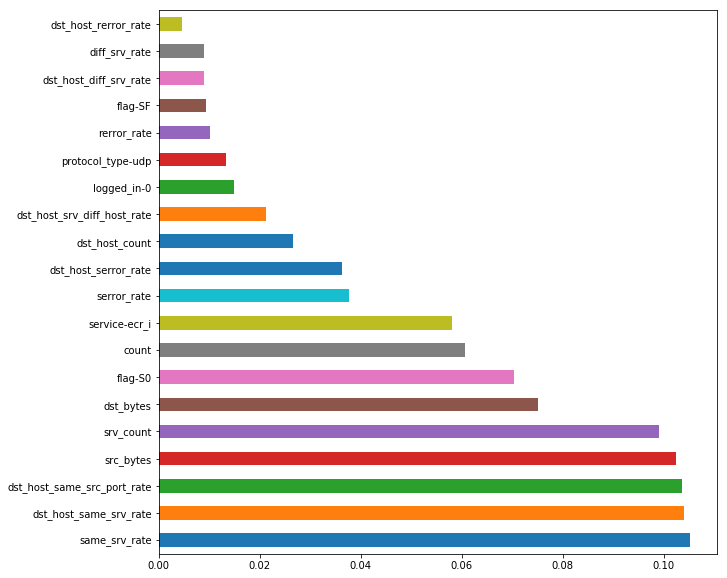

In [29]:
cols = relevant_columns(df, 'outcome', 20)
cols

In [30]:
df = df[cols]

In [31]:
# Train the Neural Network
from sklearn.model_selection import train_test_split

# Break into X (predictors) & y(prediction)
x, y = to_xy(df,'outcome')

# Create test/train split, 25% test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Create neural net
model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5",verbose=0,save_best_only=True) #save best model
model.fit(x,y,validation_data=(X_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights("best_weights.hdf5") # Load weights from best model

C:\Users\hamar\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 494021 samples, validate on 123506 samples
Epoch 1/1000
24s - loss: 0.0829 - val_loss: 0.0343
Epoch 2/1000
20s - loss: 0.0305 - val_loss: 0.0268
Epoch 3/1000
20s - loss: 0.0253 - val_loss: 0.0221
Epoch 4/1000
23s - loss: 0.0222 - val_loss: 0.0190
Epoch 5/1000
23s - loss: 0.0213 - val_loss: 0.0190
Epoch 6/1000
22s - loss: 0.0211 - val_loss: 0.0180
Epoch 7/1000
23s - loss: 0.0195 - val_loss: 0.0163
Epoch 8/1000
22s - loss: 0.0193 - val_loss: 0.0172
Epoch 9/1000
23s - loss: 0.0186 - val_loss: 0.0170
Epoch 10/1000
24s - loss: 0.0173 - val_loss: 0.0160
Epoch 11/1000
22s - loss: 0.0181 - val_loss: 0.0158
Epoch 12/1000
23s - loss: 0.0177 - val_loss: 0.0147
Epoch 13/1000
22s - loss: 0.0170 - val_loss: 0.0141
Epoch 14/1000
22s - loss: 0.0163 - val_loss: 0.0382
Epoch 15/1000
23s - loss: 0.0168 - val_loss: 0.0149
Epoch 16/1000
23s - loss: 0.016

In [37]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))

Validation score: 0.9972632908522663


In [43]:
target_labels = ['back.', 'buffer_overflow.', 'ftp_write.', 'guess_passwd.',
       'imap.', 'ipsweep.', 'land.', 'loadmodule.', 'multihop.',
       'neptune.', 'nmap.', 'normal.', 'perl.', 'phf.', 'pod.',
       'portsweep.', 'rootkit.', 'satan.', 'smurf.', 'spy.', 'teardrop.']

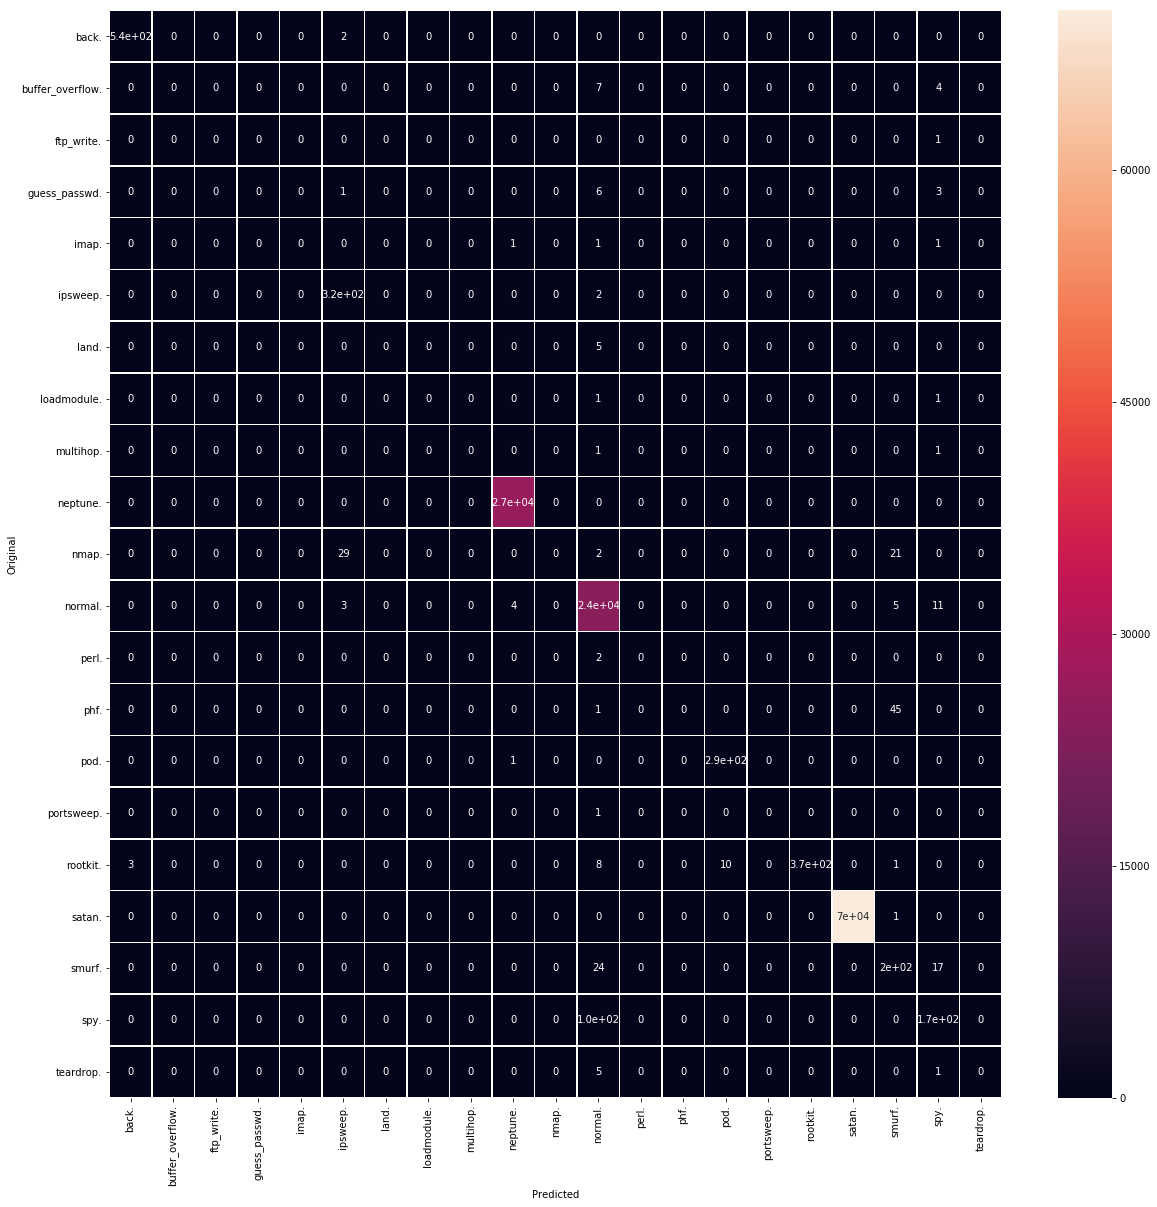

In [44]:
from sklearn.metrics import confusion_matrix
Cm = confusion_matrix(y_eval,pred)
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(Cm, linewidths=.5, xticklabels=target_labels, yticklabels=target_labels, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Original')
plt.show()